# Assignment 2: ICP and Pose Graph Optimisation

Roll number: 2019101068

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using an anaconda distribution or at the minimum, virtual environments for this assignment. 
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- You are not allowed to use any external libraries (other than ones being imported below). You can import functions provided in helper library, if any.
- Make sure any extra files that you need to submit are placed in the *'results'* folder.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- The **deadline** for this assignment is on **14/09/2022 at 11:55pm**. Please note that there will be no extensions.
- Plagiarism is **strictly prohibited**.


In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
import copy
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 2. Posegraph Optimisation


## **First of all before moving ahead, briefly explain `SLAM`.**

SLAM involves constructing or updating a map of an unknown environment while simultaneously keeping track of an agent's location within it.

SLAM addresses the problem of acquiring a spatial map of a mobile robot environment
while simultaneously localizing the robot relative to
this model.

If a sensor like lidar had zero noise and if correspondences were known, then there would be no need for explicit odometry measurements as the robot's position could then be accurately be determined using something like ICP.

If the odometry measurements were accurate, then there would be NO explicit need for mapping as the original measurements by sensor like Lidar (which kight have some noise) will be the best we can do.

In the most common SLAM setting, the robot is equipped with sensors that measure its own movements (e.g. odometry) and
other sensors that perceive its surroundings (e.g. a laser range finder, sonar sensors, or a camera). In order to map the collected information about the environment, the robot has to know its position and orientation relative to the map. It therefore has to constantly localize itself in the environment with the help of the still incomplete (and likely inaccurate) map.

### ---------------------------------




In this subsection, we are going to work with SLAM backend in a broad sense. We'll be dealing with only the **localization part of SLAM** here, i.e, 
defining the 
* motion model
* residuals & corresponding Jacobian matrix
* optimisations for non-linear least squares using Gradient descent, Gauss Newton and Levenberg–Marquardt. 

Since, one can draw correspondences in each step for 1-D and 2-D motion model, 1-D can be easily understood and 2-D can be just an extension of the 1-D case. Refer `helpers/1D-SLAM.ipynb` file for 1D-SLAM example.


## 2.1: 1-D SLAM

You have to replicate the example provided for 1D-SLAM via code from scratch. Follow below steps:-

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints.
4. Take an appropriate confidence matrix / covariance matrix / information matrix. **Mention the importance of the information matrix**.
5. Create the final Jacobian by analysing yourself and verify it using jax's jacobian(explained in `helpers/Jax.ipynb`).
6. Compute the best final pose estimate using **Gauss-Newton iterative optimiser** by implementing it from scratch.

**Reference:** Update rules for different optimisers:


- Gradient Descent

$$\delta x = -J^T \Omega^\top f(x)$$

- Gauss Newton

$$ \delta \mathbf{x} = - \left ( \mathbf{J^\top \cdot \Sigma^{-1} \cdot J} \right )^{-1} \; \cdot \;  \mathbf{J^\top \cdot \Sigma^{-1} \cdot f(x)} $$

- Levenberg Marquardt

$$ \delta x = - \left ( \mathbf{J^\top \cdot \Omega \cdot J} + \lambda \mathbf{I} \right )^{-1} \cdot \mathbf{J^\top \cdot \Omega^\top \cdot f(x)} $$

$$ \text{Note : information matrix} = \Omega = \Sigma^{-1} = \text{inverse of covariance matrix} $$


#### Generating the data
The robot drives through its 1D environment and closes a loop by returning to its starting
point.
* Number of odometry constraints = 4
* Number of loop closure constraints = 1


The error for the 4 odometry constraints are of the form $\left\|f\left(\mathbf{x}_{i}, \mathbf{u}_{i}\right)-\mathbf{x}_{i+1}\right\|_{\mathbf{\Sigma}_{i}}^{2}$ and the error for the one loop closure constraint is of the form $\left\|f\left(\mathbf{x}_{0}, \mathbf{u}_{0,4}\right)-\mathbf{x}_{4}\right\|_{\mathbf{\Lambda}_{0,4}}^{2}$.


Standard deviations for both the constraints are initialized as $0.1$. ($\boldsymbol{\sigma}_{i}=0.01 \text { and } \boldsymbol{\lambda}_{0,4}=0.01$)

In [2]:
NUM_NODES = 5

x_gt = [0, 1, 2, 3, 0]

u_obs = [1.1, 1, 1.1, -2.7, 0]


odom_std = 0.1

loop_closure_std = 0.1

x_origin = 0


# Let us calculate what will be the poses of the robot guessed if we go by odometry measurements alone
x_est = [0]
for i in range(4):
    x_est.append(x_est[-1]+u_obs[i])
print("x_est (initial guess of the robot poses according to odometry) is ", x_est)

x_est (initial guess of the robot poses according to odometry) is  [0, 1.1, 2.1, 3.2, 0.5]


Defining the function which takes: current position and odometry/loop closure measurement as input and outputs the next position based on this odometry/loop closure measurement. This function will depend on whether the odometry measurement is a rotation matrix, a quaternion etc.

In our case, due to the motion being 1D in nature, this function is simply an add function.

In [3]:
def f_new_pose(curr_pose, constraint_obs):
    return curr_pose + constraint_obs

We also add an **anchor constraint** to the list of constraints. This is to set an absolute coordinate for $x_0$

In [4]:
def calculate_residuals(x_curr_guess, U_OBS):
    # determining how far is the current guess OFF from satisying the odometry constraints
    
    NUM_ORG_CONSTRAINTS = 4 + 1
    
    err_vec = []
    for i in range(NUM_ORG_CONSTRAINTS):
        idx_of_prev_pos = i
        idx_of_next_pos = (i+1)%5
        new_pose_est = f_new_pose(x_curr_guess[idx_of_prev_pos], U_OBS[idx_of_prev_pos])
        
        # error due to this constraint
        err = new_pose_est  - x_curr_guess[idx_of_next_pos]
        
        if i == NUM_ORG_CONSTRAINTS-1:
            # loop constraint is 
            err  = (x_curr_guess[0] + U_OBS[idx_of_prev_pos]) - x_curr_guess[-1]
        
        err_vec.append(err)
        
    # append the error due to anchor constraint
    err = x_curr_guess[0] - 0
    err_vec.append(err)
    
    return jnp.asarray(err_vec)

In [5]:
calculate_residuals(x_est, u_obs)

INFO - 2022-09-20 20:59:15,664 - xla_bridge - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO - 2022-09-20 20:59:15,664 - xla_bridge - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO - 2022-09-20 20:59:15,665 - xla_bridge - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO - 2022-09-20 20:59:15,666 - xla_bridge - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING - 2022-09-20 20:59:15,667 - xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


DeviceArray([ 0. ,  0. ,  0. ,  0. , -0.5,  0. ], dtype=float32)

### {TODO} **First of all before moving ahead, briefly explain `INFORMATION MATRICES INTUITION`.**

The information matrix Ω is formed by the inverse of the matrix constructed using the standard deviations. Intuitively, the lower the standard deviation is, the better the reliability and hence, the weightage of the constraint.

In the 1-d case, we can encode the information matrix as a vector.

In [6]:
anchor_variance = 0.001
inf_vec = [(1/odom_std)**2]*4 + [(1/loop_closure_std)**2] + [1/anchor_variance]
print("Weights are : ", inf_vec)
inf_mat = np.zeros((6, 6))

Weights are :  [100.0, 100.0, 100.0, 100.0, 100.0, 1000.0]


In [7]:
for i in range(6):
    inf_mat[i, i] = inf_vec[i]

In [8]:
inf_mat

array([[ 100.,    0.,    0.,    0.,    0.,    0.],
       [   0.,  100.,    0.,    0.,    0.,    0.],
       [   0.,    0.,  100.,    0.,    0.,    0.],
       [   0.,    0.,    0.,  100.,    0.,    0.],
       [   0.,    0.,    0.,    0.,  100.,    0.],
       [   0.,    0.,    0.,    0.,    0., 1000.]])

In [9]:
analytical_jacobian = jnp.array(
                    [[1, -1, 0, 0, 0], #derivative of x0+u0-x1
                   [0, 1, -1, 0, 0], #derivative of x1+u1-x2
                   [0, 0, 1, -1, 0], #derivative of x2+u2-x2
                   [0, 0, 0, 1, -1], #derivative of x3+u3-x3
                   [1, 0, 0, 0, -1], #derivative of x0+u4 - (x4): by defn of the loop closure
                   [1, 0, 0, 0, 0], #derivative of x0 - 0
                  ])

`jacfwd` uses forward-mode automatic differentiation, which is more efficient for “tall” Jacobian matrices, while `jacrev` uses reverse-mode, which is more efficient for “wide” Jacobian matrices. For matrices that are near-square, `jacfwd` probably **has an edge** over jacrev.

### See what the derivative is as per jax

In [10]:
f = lambda X: calculate_residuals(X, u_obs) # Now f is just a function of variable to be differentiated
J = jax.jacfwd(f)

In [11]:
jacobian_as_per_jax = J(jnp.asarray(x_est))

In [12]:
jnp.isclose(analytical_jacobian, jacobian_as_per_jax)

DeviceArray([[ True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True]], dtype=bool)

#### Now, let us perform gaussian newton optimization iteratively from scratch

In [13]:
analytical_jacobian

DeviceArray([[ 1, -1,  0,  0,  0],
             [ 0,  1, -1,  0,  0],
             [ 0,  0,  1, -1,  0],
             [ 0,  0,  0,  1, -1],
             [ 1,  0,  0,  0, -1],
             [ 1,  0,  0,  0,  0]], dtype=int32)

In [14]:

residuals = calculate_residuals(x_est, u_obs) # (6,1)
ABS_ERR = int(residuals.T@inf_mat@residuals)

In [15]:
ABS_ERR

25

In [16]:
x_est

[0, 1.1, 2.1, 3.2, 0.5]

In [17]:
NUM_ITRS = 10

err_tracker = [ABS_ERR]

for curr_itr_num in range(1, NUM_ITRS+1):
    
    print("Curr itr number is ", curr_itr_num)
    print("Estimate of pose at start of iteration is ", list(np.around(np.array(x_est),2)))
    
    #Due to the linear odometry and loop closure functions, the jacobian does not change 
    #with change in pose. 
    # Even then, for sake of uniformity, let us caluclate J again and again
    J = analytical_jacobian # size = (6 x 5)
    
    # calculate error
    # calculate H and b
    
    #H = J_t x Ω x J
    H = J.T@inf_mat@J # (5 x 6) x (6 x 6) (6 x 5) = (5 x 5)
    
    # f(x0) is the error at the current estimated guessed pose
    curr_err = calculate_residuals(x_est, u_obs)
    print("residuals are ", list(np.around(np.array(curr_err),2)))
    
    # b = J_t x Ω_t x f(x0)
    b = J.T@inf_mat.T@curr_err # (5 x 6) (6 x 6) (6 x 1) = (5 x 1)
    
    # (5 x 5) 
    dx = np.linalg.inv(H)@(-b)
    print("dx is ", list(np.around(np.array(dx),2)))
    
    #x_new=x_now+dx
    ALPHA = 1
    x_est = [a + ALPHA * b for a, b in zip(x_est, dx)]

    
    new_residuals = calculate_residuals(x_est, u_obs) # (6,1)
    ABS_ERR = 0.5*float(new_residuals.T@inf_mat@new_residuals)
    print("new residuals are ", list(np.around(np.array(new_residuals),2)))
    print("new error is ", ABS_ERR)
    err_tracker.append(ABS_ERR)
    
    
    
    
    # find best dx using H and b
    
    # make changes to current estimate to fetch new estimate
    
    print("########################")

Curr itr number is  1
Estimate of pose at start of iteration is  [0.0, 1.1, 2.1, 3.2, 0.5]
residuals are  [0.0, 0.0, 0.0, 0.0, -0.5, 0.0]
dx is  [-0.0, -0.1, -0.2, -0.3, -0.4]
new residuals are  [0.1, 0.1, 0.1, 0.1, -0.1, -0.0]
new error is  2.5000011920928955
########################
Curr itr number is  2
Estimate of pose at start of iteration is  [-0.0, 1.0, 1.9, 2.9, 0.1]
residuals are  [0.1, 0.1, 0.1, 0.1, -0.1, -0.0]
dx is  [0.0, -0.0, 0.0, -0.0, -0.0]
new residuals are  [0.1, 0.1, 0.1, 0.1, -0.1, -0.0]
new error is  2.5
########################
Curr itr number is  3
Estimate of pose at start of iteration is  [-0.0, 1.0, 1.9, 2.9, 0.1]
residuals are  [0.1, 0.1, 0.1, 0.1, -0.1, -0.0]
dx is  [-0.0, 0.0, 0.0, -0.0, -0.0]
new residuals are  [0.1, 0.1, 0.1, 0.1, -0.1, -0.0]
new error is  2.5
########################
Curr itr number is  4
Estimate of pose at start of iteration is  [-0.0, 1.0, 1.9, 2.9, 0.1]
residuals are  [0.1, 0.1, 0.1, 0.1, -0.1, -0.0]
dx is  [0.0, 0.0, 0.0, -0.0, 0.0

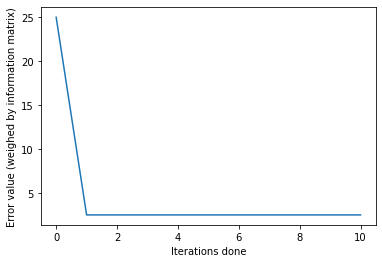

In [18]:
plt.xlabel("Iterations done")
plt.ylabel("Error value (weighed by information matrix)")
plt.plot(err_tracker)

In [19]:
print(*list(zip(x_gt, list(np.asarray(x_est)))), sep="\n")

(0, -3.2782546e-10)
(1, 1.0)
(2, 1.9)
(3, 2.9)
(0, 0.1)
